In [1]:
from tensorly.decomposition import non_negative_tucker
import tensorly as tl
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import itertools
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Reading in data

In [2]:
# this should be the main cells file provided with the manuscript
path_to_data = '/Path/to/your/file.csv'
cells = pd.read_csv(path_to_data)

# Isolate patient identifiers and groups
patient_to_group_dict = cells.loc[:,['patients','groups']].drop_duplicates().set_index('patients').to_dict()['groups']
group1_patients = [a for a,gp in patient_to_group_dict.items() if gp==1]
group2_patients = [a for a,gp in patient_to_group_dict.items() if gp==2]
print(group1_patients)
print(group2_patients)

[1, 6, 10, 11, 12, 13, 17, 19, 20, 21, 24, 28, 29, 32, 33, 34, 35]
[2, 3, 4, 5, 7, 8, 9, 14, 15, 16, 18, 22, 23, 25, 26, 27, 30, 31]


In [3]:
cells['patients'] = cells['patients'].astype('category')
cells['neighborhood10'] = cells['neighborhood10'].astype('category')
cells['ClusterName'] = cells['ClusterName'].astype('category')

In [4]:
# select the cts (17 kinds)
cts = ['CD11b+CD68+ macrophages',
 'tumor cells / immune cells',
 'adipocytes',
 'CD68+ macrophages',
 'immune cells / vasculature',
 'CD4+ T cells',
 'Tregs',
 'plasma cells',
 'vasculature',
 'B cells',
 'CD4+ T cells CD45RO+',
 'CD8+ T cells',
 'stroma',
 'granulocytes',
 'smooth muscle',
 'CD68+CD163+ macrophages',
 'tumor cells']

# select the cns (9 kinds)
cns = [0,2,3,4,6,7,8,9]

# Build the tensors for each patient group

In [5]:
counts = cells.groupby(['patients','neighborhood10','ClusterName']).size()

print(counts)

patients  neighborhood10  ClusterName               
1         0               B cells                       63
                          CD11b+ monocytes               0
                          CD11b+CD68+ macrophages        1
                          CD11c+ DCs                     2
                          CD163+ macrophages             0
                                                        ..
35        9               stroma                         8
                          tumor cells                    5
                          tumor cells / immune cells     1
                          undefined                      8
                          vasculature                    4
Length: 10150, dtype: int64


In [8]:
def plot_modules_heatmap_test(dat,num_tissue_modules = 1, num_cn_modules = 6):
    figsize(30,20)
    core, factors = non_negative_tucker(dat,rank=[num_tissue_modules,num_cn_modules,num_cn_modules],random_state = 32)
    plt.subplot(2,2,1)
    sns.heatmap(pd.DataFrame(factors[1],index = cns), cmap="coolwarm")
    plt.ylabel('CN')
    plt.xlabel('CN module')
    plt.title('Loadings onto CN modules')
    plt.subplot(2,2,2)
    sns.heatmap(pd.DataFrame(factors[2],index = cts), cmap="coolwarm")
    plt.ylabel('CT')
    plt.xlabel('CT module')
    plt.title('Loadings onto CT modules')
    plt.show()
    plt.subplot(2,2,3)
    sns.heatmap(pd.DataFrame(factors[0]), cmap="coolwarm")
    plt.ylabel('Patient')
    plt.xlabel('Tissue module')
    plt.title('Loadings onto tissue modules')
    plt.show()
    plt.subplot(2,2,4)
    sns.heatmap(pd.DataFrame(core[0]), cmap="coolwarm")
    plt.ylabel('Patient')
    plt.xlabel('Tissue module')
    plt.title('Loadings onto tissue modules')
    plt.show()
    
    print(core)
    print(factors[0])

In [12]:
#initialize the tensors
T1 = np.zeros((len(group1_patients),len(cns),len(cts)))
#There are 'len(group1_patients)' zero matrix with size of (len(cns),len(cts))
T2 = np.zeros((len(group2_patients),len(cns),len(cts)))

#Put the CTs and CNs data into matrix
for i,pat in enumerate(group1_patients):
    for j,cn in enumerate(cns):
        for k,ct in enumerate(cts):
            T1[i,j,k] = counts.loc[(pat,cn,ct)]  
#counts -> first layer: patients; second-layer: neighbors; third layer: cell types
            
for i,pat in enumerate(group2_patients):
    for j,cn in enumerate(cns):
        for k,ct in enumerate(cts):
            T2[i,j,k] = counts.loc[(pat,cn,ct)]

#normalize the counts by patients, so we could joint distributions from each slice
dat1 =np.nan_to_num(T1/T1.sum((1,2), keepdims = True))
dat2 =np.nan_to_num(T2/T2.sum((1,2), keepdims = True))
print(dat1)

[[[1.89717321e-04 1.89717321e-04 4.17378107e-03 ... 1.89717321e-03
   9.29614874e-03 3.60462910e-03]
  [0.00000000e+00 1.89717321e-03 7.58869285e-04 ... 2.46632518e-03
   1.89717321e-03 3.84936445e-01]
  [3.79434642e-04 0.00000000e+00 9.48586606e-04 ... 2.27660785e-03
   1.46082337e-02 3.22519446e-03]
  ...
  [1.89717321e-04 3.79434642e-04 1.13830393e-03 ... 3.45285525e-02
   1.29007778e-02 8.72699677e-03]
  [0.00000000e+00 3.79434642e-04 5.69151964e-04 ... 4.17378107e-02
   2.27660785e-03 2.08689053e-03]
  [0.00000000e+00 0.00000000e+00 3.79434642e-04 ... 7.58869285e-04
   9.48586606e-04 1.13830393e-03]]

 [[3.96353547e-04 2.93301625e-02 6.34165676e-03 ... 2.37812128e-03
   1.46650813e-02 2.61593341e-02]
  [0.00000000e+00 1.98176774e-04 1.98176774e-04 ... 0.00000000e+00
   1.98176774e-04 2.69520412e-02]
  [7.92707095e-04 2.17994451e-03 2.37812128e-03 ... 2.47720967e-02
   1.68450258e-02 2.23939754e-02]
  ...
  [3.96353547e-04 7.92707095e-04 5.94530321e-04 ... 4.65715418e-02
   9.71066

# The following tries different numbers of CN modules/CT modules to determine suitable rank for decomposition

In [13]:
def evaluate_ranks(dat, num_tissue_modules):
    
    mat1 = np.zeros((num_tissue_modules,15))
    for i in range(2,15):
        for j in range(1,num_tissue_modules):
            # we use NNTD as described in the paper
            facs_overall = non_negative_tucker(dat,rank=[j,i,i],random_state = 2336) # decomposition, [0]core; [1]factor
            mat1[j,i] = np.mean((dat- tl.tucker_to_tensor((facs_overall[0],facs_overall[1])))**2)
            # Calculate mean square error
    for j in range(1,num_tissue_modules):
        plt.plot(2+np.arange(13),mat1[j][2:],label = 'rank = ({},x,x)'.format(j))
        
    plt.xlabel('x')
    plt.ylabel('reconstruction error')
    plt.legend()
    plt.show()
    

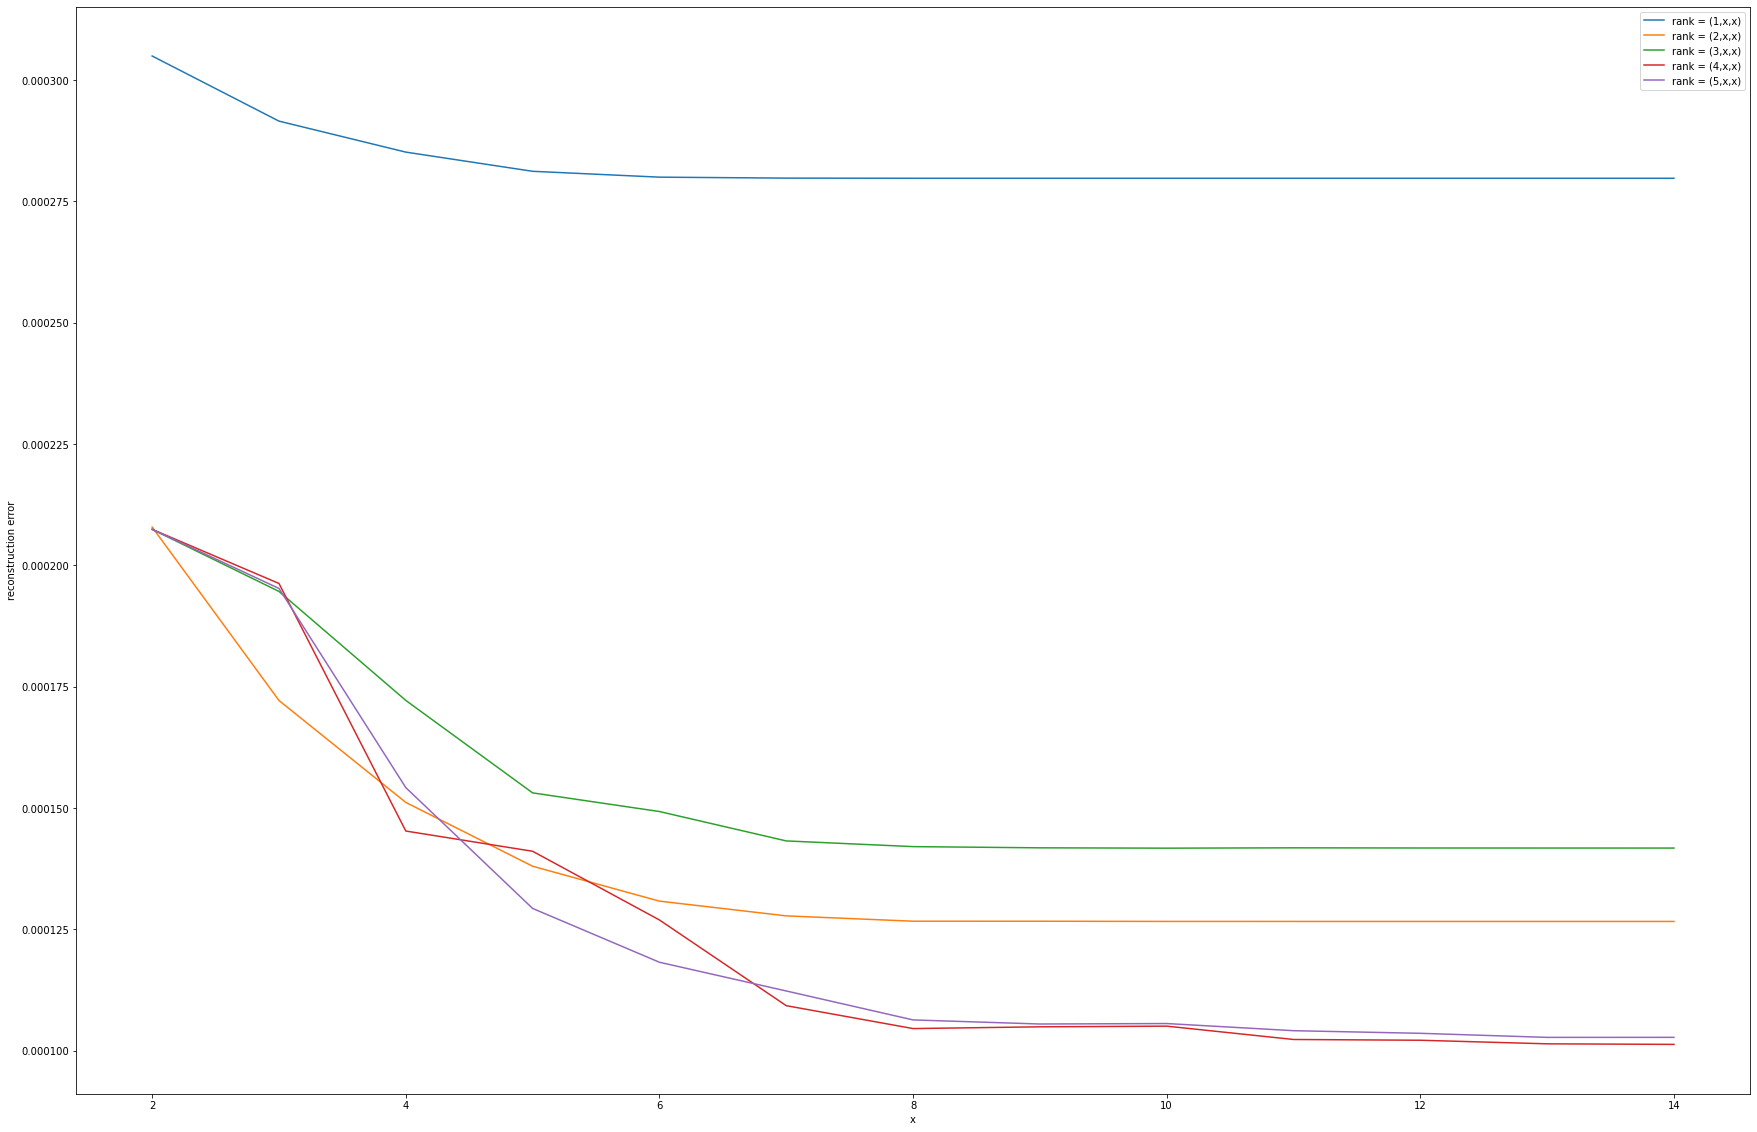

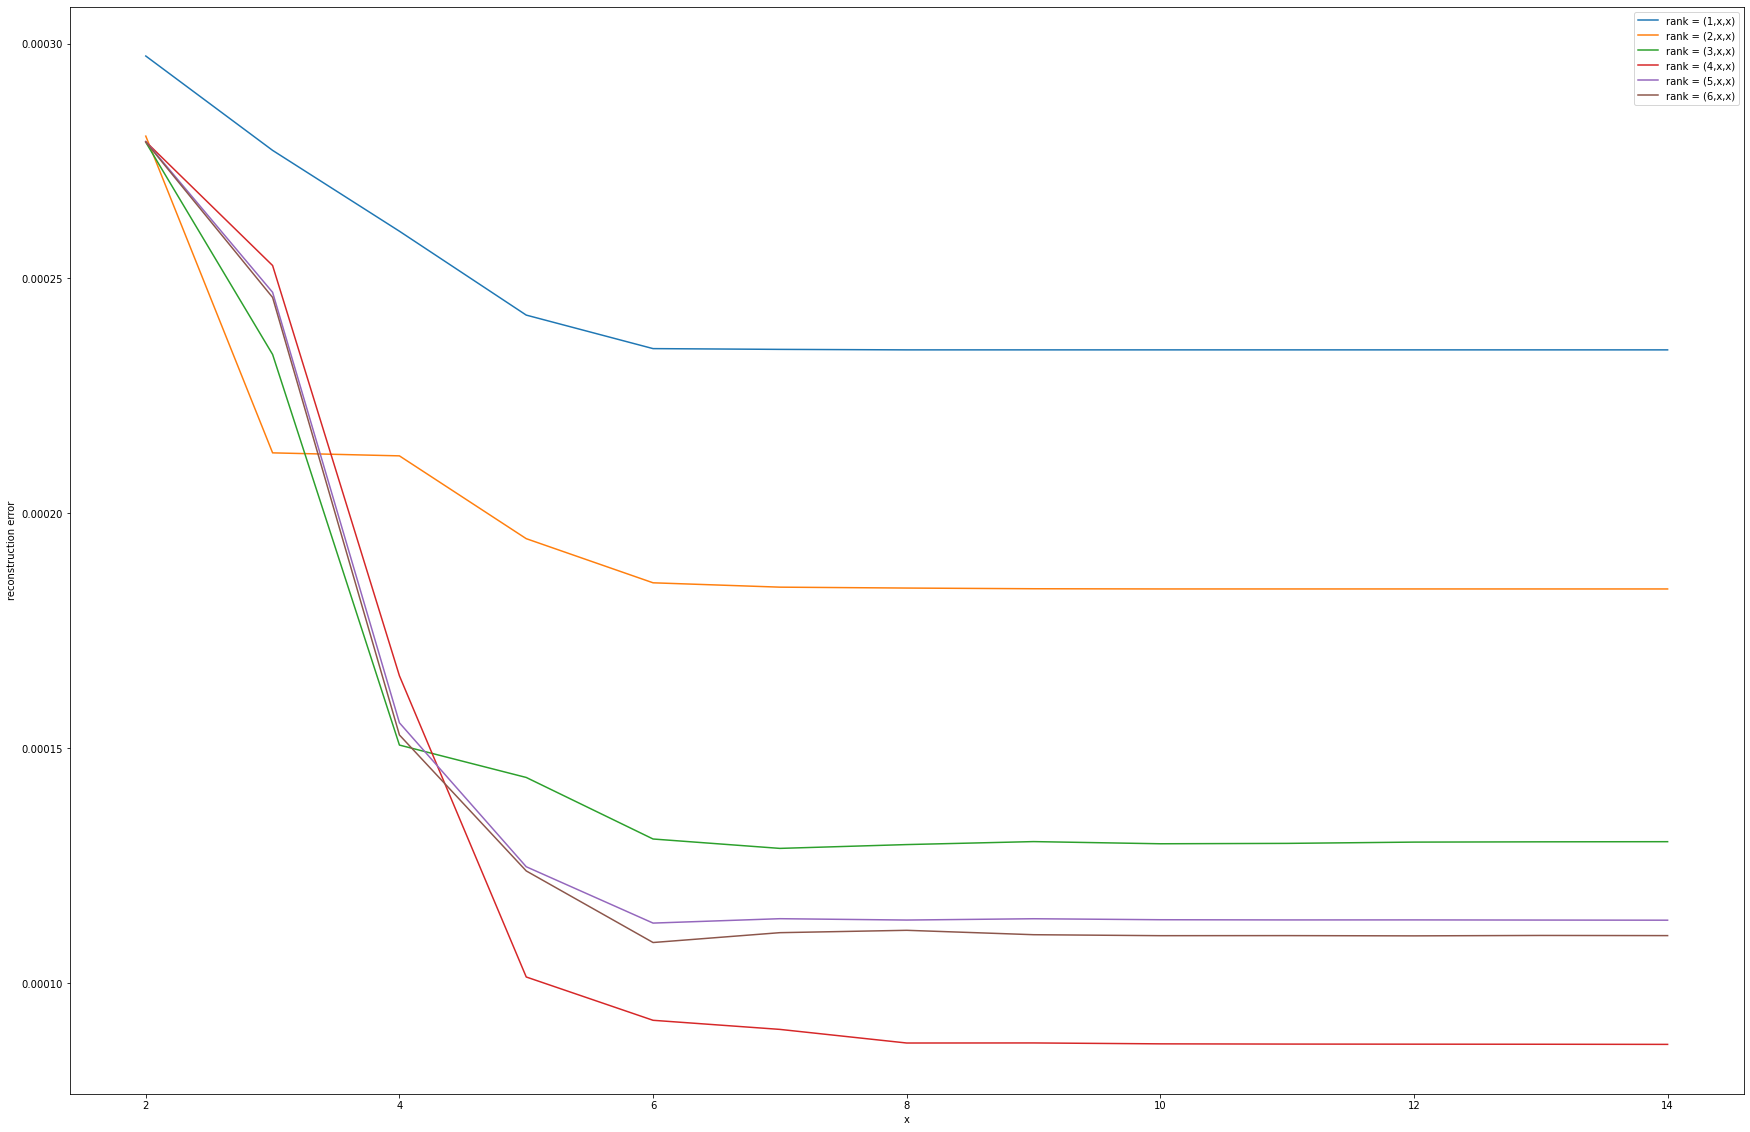

In [14]:
evaluate_ranks(dat1,6)
plt.show()
evaluate_ranks(dat2,7)
plt.show()

In [15]:
def evaluate_ranks1(dat):
    
    mat1 = np.zeros((15,15))
    for i in range(2,15):
        for j in range(2,15):
            # we use NNTD as described in the paper
            facs_overall = non_negative_tucker(dat,rank=[2,i,j],random_state = 2336) # decomposition, [0]core; [1]factor
            mat1[j,i] = np.mean((dat- tl.tucker_to_tensor((facs_overall[0],facs_overall[1])))**2)
            # Calculate mean square error
    for j in range(2,15):
        plt.plot(2+np.arange(13),mat1[j][2:],label = 'rank = (2,{},x)'.format(j))
        
    plt.xlabel('x')
    plt.ylabel('reconstruction error')
    plt.legend()
    plt.show()

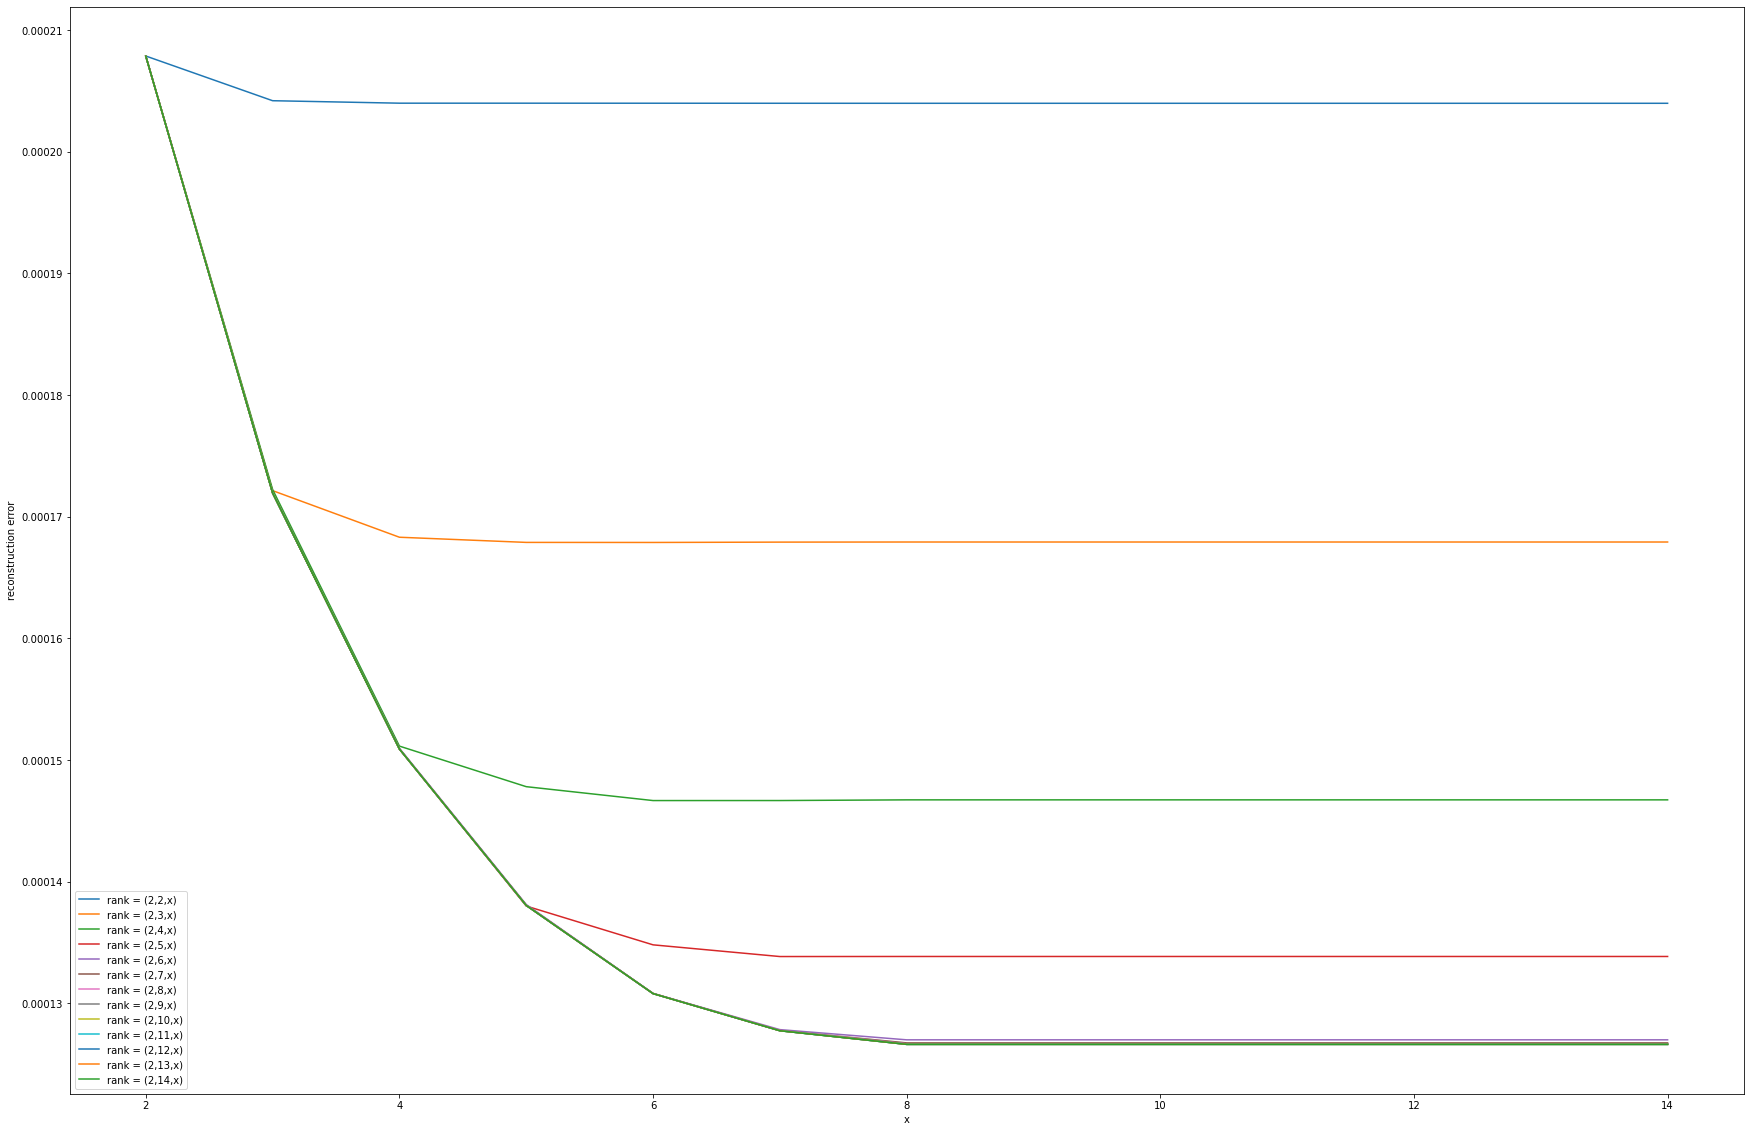

In [16]:
evaluate_ranks1(dat1)
plt.show()

# The following visualizes the tensor decomposition output
- The exact sizing of the font and aesthetics is difficult to adjust for different sizes and will have to be optimized for number of cell types/cns and intended figure size for your paper.
- Therefore, I have also included a simpler/more conventional visualization of tensor decomposition (plot_modules_heatmap). Only if this analysis is interesting, is it worth proceeding to optimize the layout. 

In [24]:
def plot_modules_heatmap(dat,num_tissue_modules = 3, num_cn_modules = 6):
    figsize(30,20)
    core, factors = non_negative_tucker(dat,rank=[num_tissue_modules,num_cn_modules,num_cn_modules],random_state = 32)
    plt.subplot(2,2,1)
    sns.heatmap(pd.DataFrame(factors[1],index = cns), cmap="plasma")
    plt.ylabel('CN')
    plt.xlabel('CN module')
    plt.title('Loadings onto CN modules')
    plt.subplot(2,2,2)
    sns.heatmap(pd.DataFrame(factors[2],index = cts), cmap="plasma")
    plt.ylabel('CT')
    plt.xlabel('CT module')
    plt.title('Loadings onto CT modules')
    plt.show()
    plt.subplot(2,2,3)
    sns.heatmap(pd.DataFrame(factors[0]), cmap="plasma")
    plt.ylabel('Patient')
    plt.xlabel('Tissue module')
    plt.title('Loadings onto tissue modules')
    plt.show()
    
    print(core)
    
    figsize(num_tissue_modules*6,6)
    for p in range(num_tissue_modules):
        plt.subplot(1, num_tissue_modules, p+1)
        sns.heatmap(pd.DataFrame(core[p]), cmap="plasma")
        plt.title('tissue module {}, couplings'.format(p))
        plt.ylabel('CN module')
        plt.ylabel('CT module')
    plt.show()

    
        
    

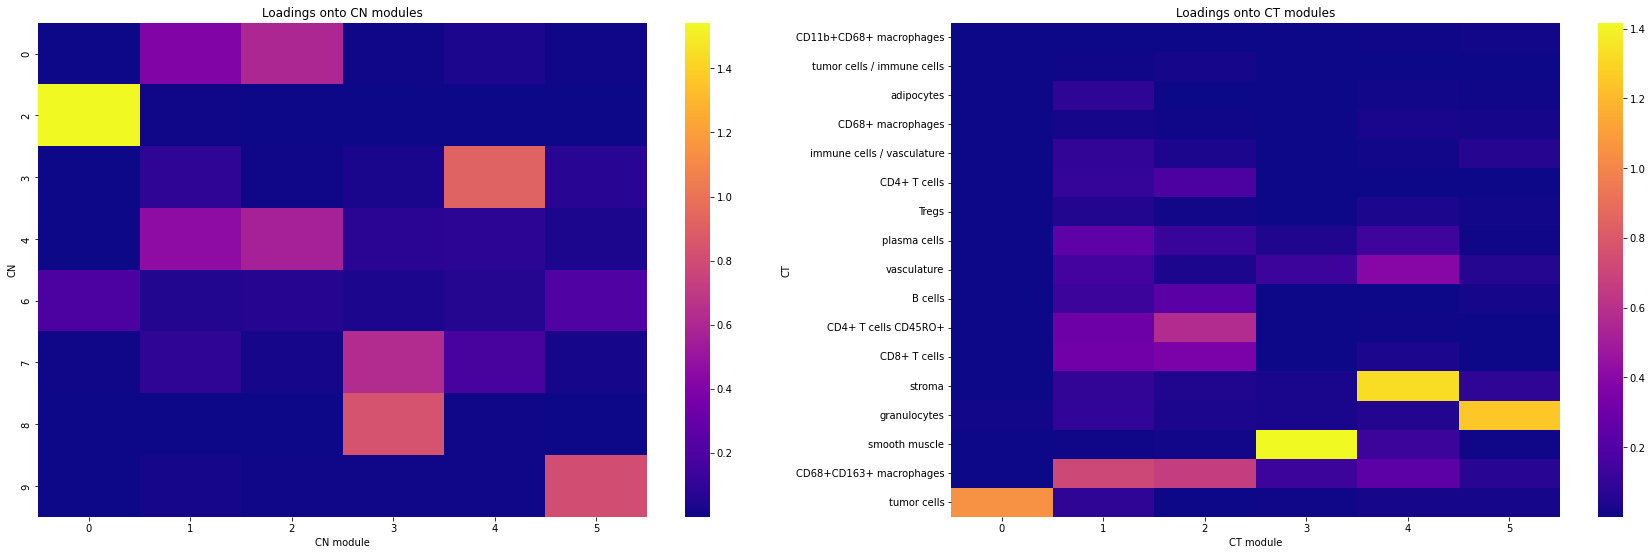

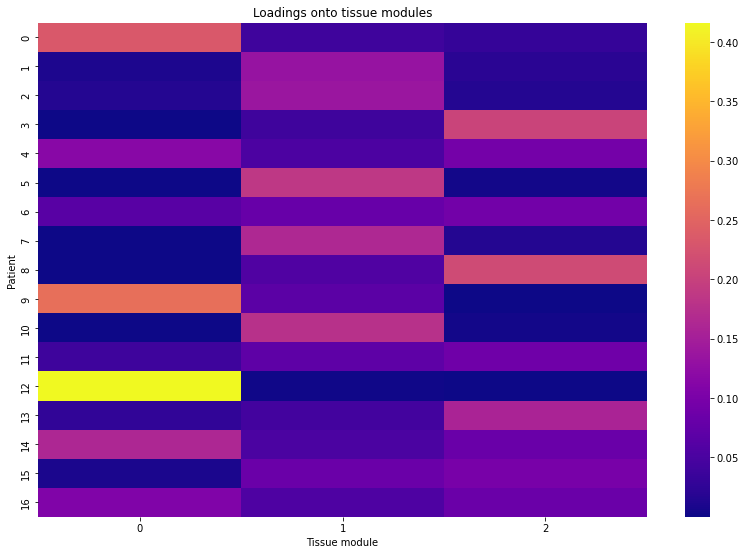

[[[1.00462864e+00 1.73096031e-02 4.55684268e-05 2.65203644e-04
   8.99127194e-04 1.42431319e-03]
  [7.58527721e-03 4.97403349e-02 3.79392735e-03 2.03186452e-04
   3.43310385e-04 3.06768015e-04]
  [1.34975632e-04 4.30347649e-03 1.63038942e-02 1.08354285e-04
   9.48683121e-04 9.87310884e-04]
  [2.39168805e-03 7.64723626e-04 4.76859725e-04 1.14418271e-01
   2.93581826e-03 4.60150476e-05]
  [1.99374752e-03 4.94887162e-04 8.79701994e-05 1.45953177e-03
   1.89590428e-02 9.50621310e-04]
  [7.06589083e-04 8.24686029e-04 6.39635110e-04 2.90442371e-04
   2.58853090e-05 1.11690504e-03]]

 [[5.05460796e-02 7.93990708e-04 3.87303788e-07 7.01605050e-05
   1.67064595e-04 1.48962326e-04]
  [4.17695173e-02 5.10609745e-01 2.20665826e-02 8.20374804e-04
   1.20487810e-02 1.12339822e-03]
  [3.84932276e-03 8.01280802e-03 3.39453496e-01 8.11159127e-03
   3.08205580e-03 1.43896806e-03]
  [6.14635174e-03 3.87543706e-03 5.97014850e-03 3.84773676e-01
   1.07206745e-02 6.03221468e-03]
  [3.84294247e-02 6.62873655

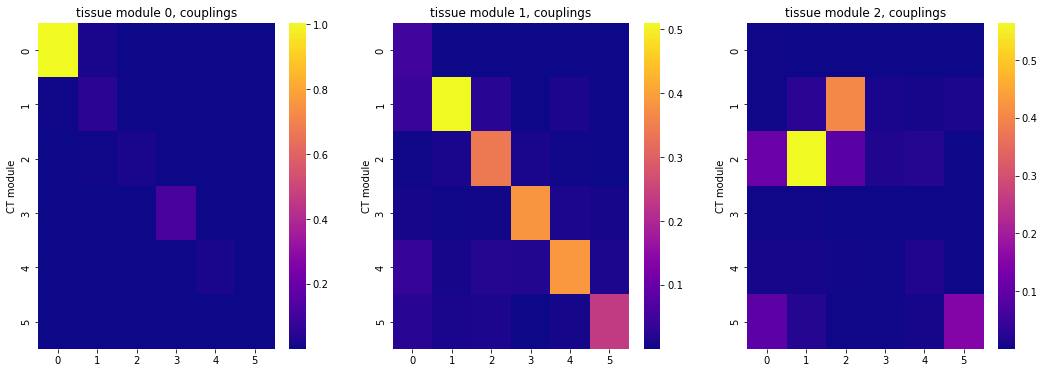

In [25]:
plot_modules_heatmap(dat1)

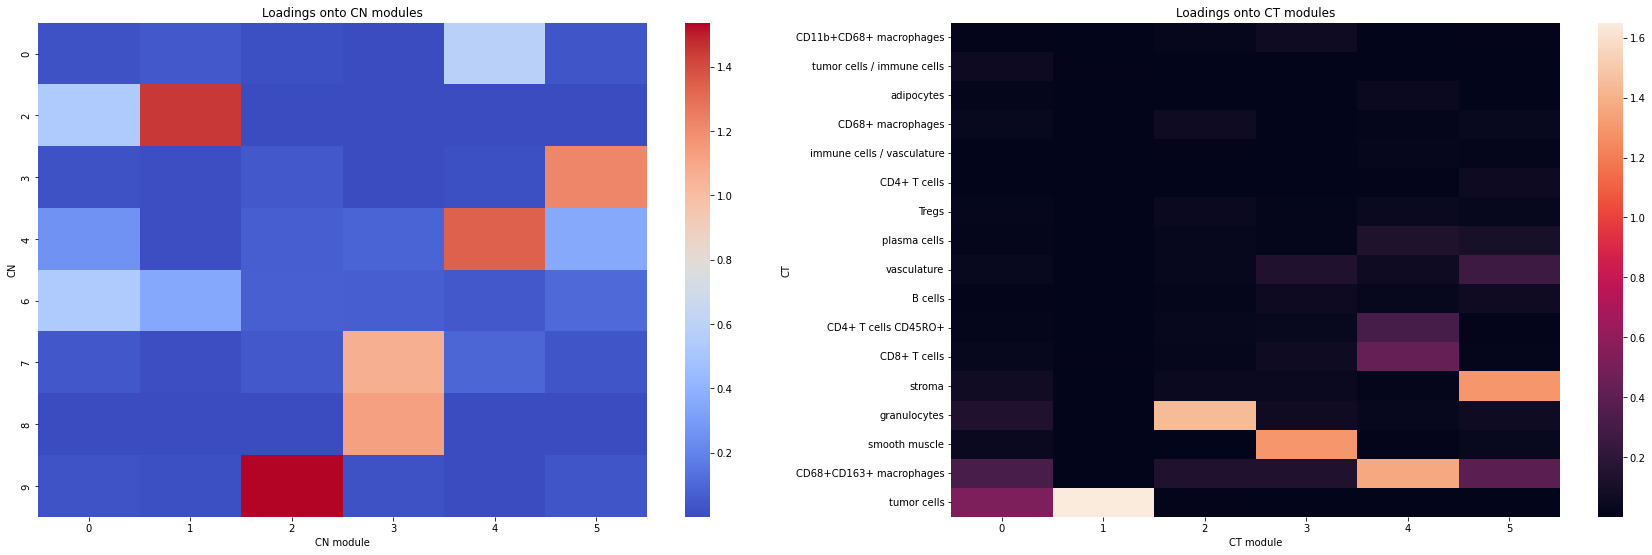

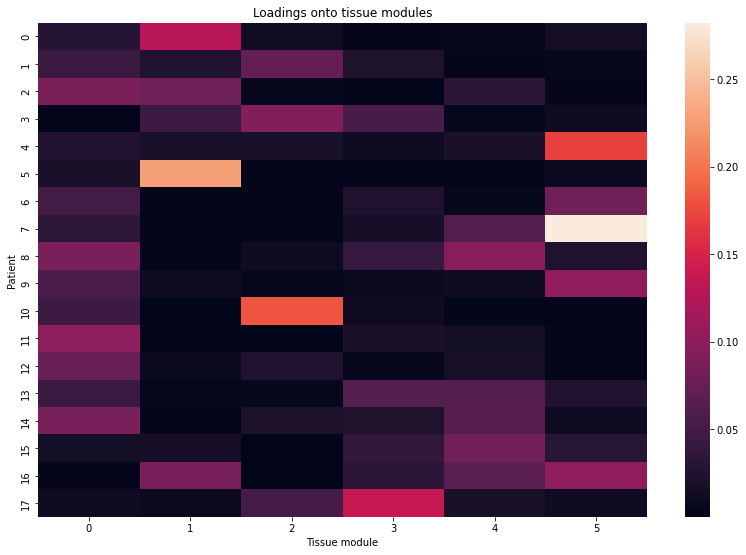

[[[4.84950566e-01 1.26120352e-01 1.25700563e-02 6.10104864e-03
   9.26172874e-03 1.17218353e-04]
  [5.11880485e-02 8.25845802e-01 5.89727400e-04 7.07906778e-05
   5.23640447e-05 1.53817045e-05]
  [1.60724869e-03 9.32496189e-05 8.86381609e-02 1.06522766e-03
   3.39621125e-03 5.98280446e-04]
  [4.09351354e-04 5.87729369e-05 1.87810608e-05 5.53362431e-02
   9.44324566e-03 6.59576516e-04]
  [4.21840239e-03 1.16684646e-04 3.86252155e-03 3.40089181e-02
   4.11184059e-01 1.44058238e-02]
  [1.33615108e-03 9.05114243e-05 4.45448456e-04 1.13522317e-02
   5.34352497e-04 6.77485549e-02]]

 [[9.67719162e-03 1.73953454e-02 8.50758090e-03 6.25292359e-04
   2.80868802e-03 4.05288749e-03]
  [4.53248479e-03 2.90693712e-02 3.91816768e-04 7.65950526e-06
   2.08105084e-05 1.05638129e-04]
  [9.82468970e-02 5.48629711e-03 6.46059414e-01 3.01635595e-02
   1.50943602e-02 2.86861275e-02]
  [2.10998098e-03 6.32270611e-05 5.06301443e-03 1.11470072e-02
   3.95428458e-04 1.93377141e-03]
  [2.65636327e-03 7.46226876

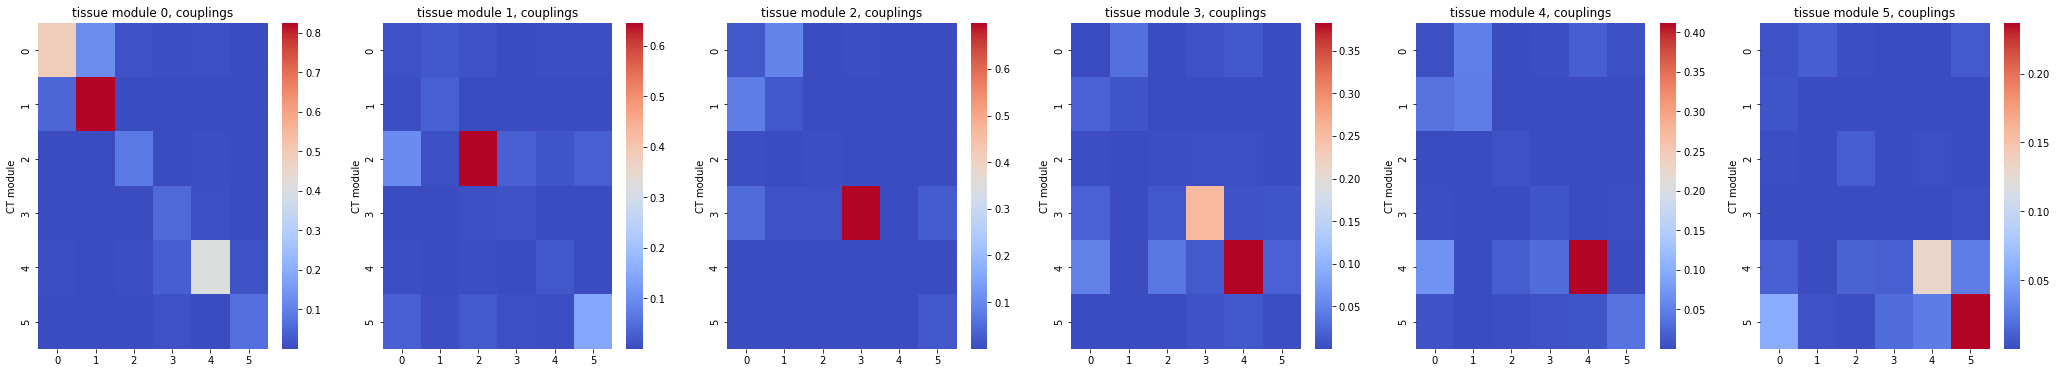

In [13]:
plot_modules_heatmap(dat2)

In [28]:
def plot_modules_graphical(dat,num_tissue_modules = 3, num_cn_modules = 6, scale = 0.4):
    core, factors = non_negative_tucker(dat,rank=[num_tissue_modules,num_cn_modules,num_cn_modules],random_state = 32)
    

    pal = sns.color_palette('bright',10)
    palg = sns.color_palette('Greys',10)
    
    figsize(3.67*scale,2.00*scale)
    cn_scatter_size = scale*scale*45
    cel_scatter_size = scale*scale*15
    
    

    for p in range(num_tissue_modules):
        for idx in range(num_cn_modules):
            an = float(np.max(core[p][idx,:])>0.1) + (np.max(core[p][idx,:])<=0.1)*0.05
            ac = float(np.max(core[p][:,idx])>0.1) + (np.max(core[p][:,idx])<=0.1)*0.05

            cn_fac = factors[1][:,idx]
            cel_fac = factors[2][:,idx]

            cols_alpha = [(*pal[cn], an*np.minimum(cn_fac, 1.0)[i]) for i,cn in enumerate(cns)]
            cols = [(*pal[cn], np.minimum(cn_fac, 1.0)[i]) for i,cn in enumerate(cns)]
            cell_cols_alpha = [(0,0,0, an*np.minimum(cel_fac, 1.0)[i]) for i,_ in enumerate(cel_fac)]
            cell_cols = [(0,0,0, np.minimum(cel_fac, 1.0)[i]) for i,_ in enumerate(cel_fac)]
            
            plt.scatter(0.5*np.arange(len(cn_fac)), 5*idx + np.zeros(len(cn_fac)), c = cols_alpha, s = cn_scatter_size)
            offset = 9
            for i,k in enumerate(cns):
                plt.text(0.5*i, 5*idx, k,fontsize = scale*2,ha = 'center', va = 'center',alpha = an)

            plt.scatter(-4.2+0.25*np.arange(len(cel_fac))+offset, 5*idx + np.zeros(len(cel_fac)), c = cell_cols_alpha, s = 0.5*cel_scatter_size)#,vmax = 0.5,edgecolors=len(cell_cols_alpha)*[(0,0,0,min(1.0,max(0.1,2*an)))], linewidths= 0.05)
            
            
            rect = plt.Rectangle((-0.5,5*idx-2 ),4.5,4,linewidth=scale*scale*1,edgecolor='black',facecolor='none',zorder = 0,alpha = an,linestyle = '--')
            ax = plt.gca()
            ax.add_artist(rect)
            plt.scatter([offset-5],[5*idx],c = 'black', marker = 'D', s = scale*scale*5, zorder = 5,alpha = an)
            plt.text(offset-5,5*idx,idx,color = 'white',alpha = an, ha = 'center', va = 'center',zorder = 6,fontsize = 4.5)
            plt.scatter([offset-4.5],[5*idx],c = 'black', marker = 'D', s = scale*scale*5, zorder = 5,alpha = ac)
            plt.text(offset-4.5,5*idx,idx,color = 'white',alpha = ac, ha = 'center', va = 'center', zorder = 6,fontsize = 4.5)

            rect = plt.Rectangle((offset-4.5,5*idx-2 ),4.5,4,linewidth=scale*1,edgecolor='black',facecolor='none',zorder = 0, alpha = ac,linestyle = '-.')
            ax.add_artist(rect)

        for i,ct in enumerate(cts):
                plt.text(-4.2+offset+0.25*i, 27.5, ct, rotation = 45, color = 'black',ha = 'left', va = 'bottom',fontsize = scale*3,alpha = 1)
        for cn_i in range(num_cn_modules):
            for cel_i in range(num_cn_modules):
                plt.plot([-3+offset -2, -4+offset - 0.5],[5*cn_i, 5*cel_i], color = 'black', linewidth =2*scale*scale*1* min(1.0, max(0,-0.00+core[p][cn_i,cel_i])),alpha = min(1.0, max(0.000,-0.00+10*core[p][cn_i,cel_i])))#max(an,ac))



        plt.ylim(-5, 30)
        plt.axis('off')
        

        plt.show()

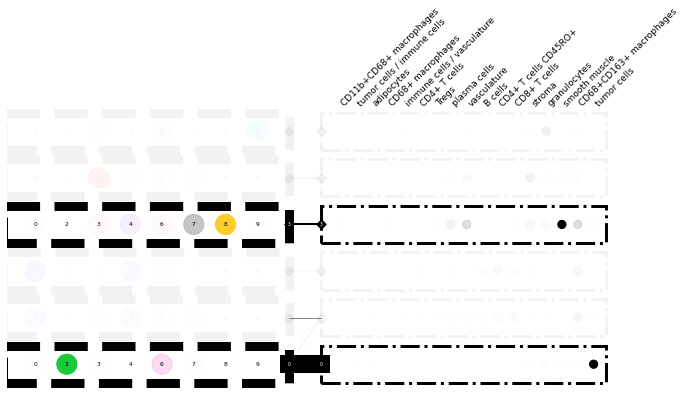

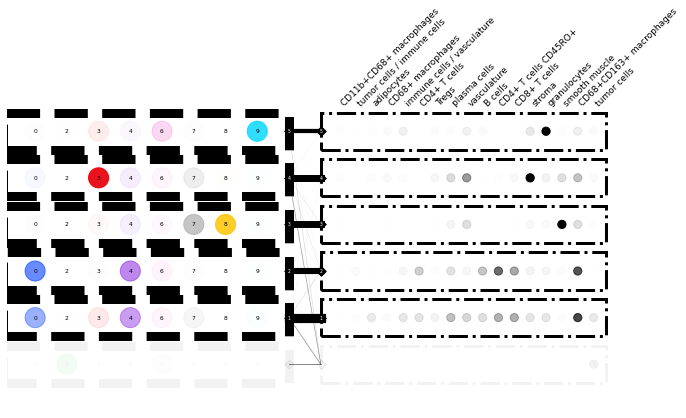

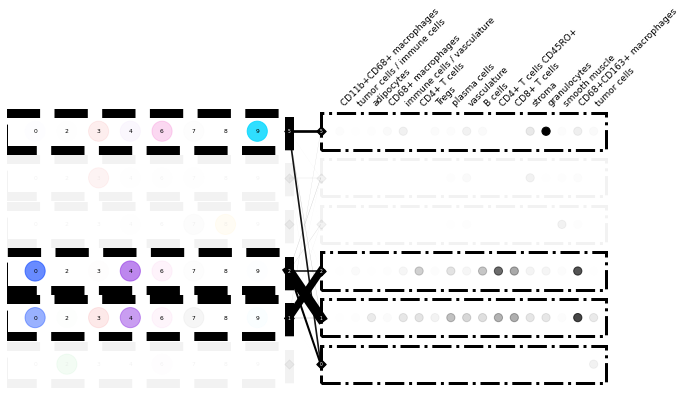

In [29]:
plot_modules_graphical(dat1,scale  = 3)

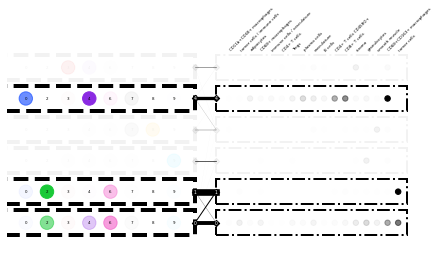

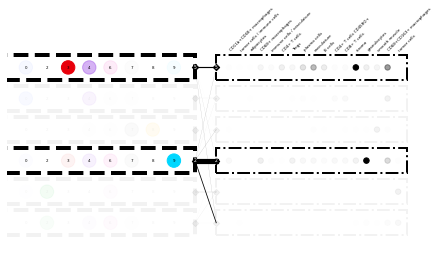

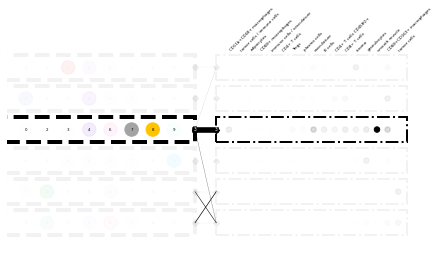

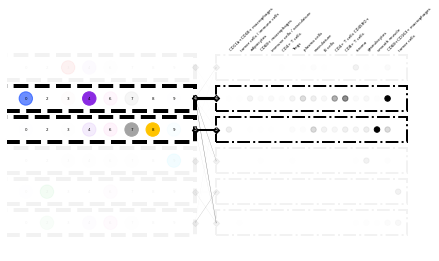

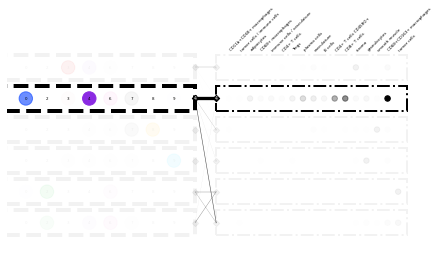

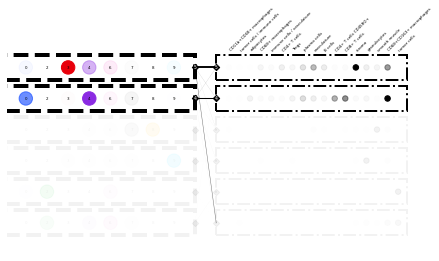

In [93]:
plot_modules_graphical(dat2,scale  = 2)